# 0 Dataset cleaning and Exploration

## Table of Contents

1. [Loading the Data and Necessary Libraries](#loading-dependencies)


## Loading the Data and Libraries 
<a class="anchor" id="loading-dependencies"></a>

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family= 'Times New Roman', size= 14)

df_c = pd.read_csv("NYT_data_2020/nyt-comments-2020.csv",low_memory=False)

## Typecasting 
<a class="anchor" id="typecasting"></a>

In [2]:
df_c.createDate = pd.to_datetime(df_c.createDate)
df_c.updateDate = pd.to_datetime(df_c.updateDate)
df_c.approveDate = pd.to_datetime(df_c.approveDate)

## Filtering data 
<a class="anchor" id="Filtering"></a>

Removieng useres that are affiliated with the NYT (Moderators and Authors)  
as well as dropping not needed rows and columns

In [3]:
df_c = df_c[df_c['userTitle'].isna()] # Selecting only users

df_c.drop('status', axis=1, inplace=True) # Status is always True
df_c.drop('userTitle', axis=1, inplace=True)
df_c.drop('isAnonymous', axis=1, inplace=True)
df_c.drop(['commentSequence','permID'], axis=1, inplace=True) #the commentID, commentSequence & permID are all ideantical and there is no isnatance that deaviates from the rule  
df_c.drop(['trusted','recommendedFlag'], axis=1, inplace=True)

## Saving Comment Cleaned comment dataset
<a class="anchor" id="saving"></a>


In [ ]:
df_c = pd.read_parquet('Comments.parquet')

## Dataset Exploration
<a class="anchor" id="Exploration"></a>

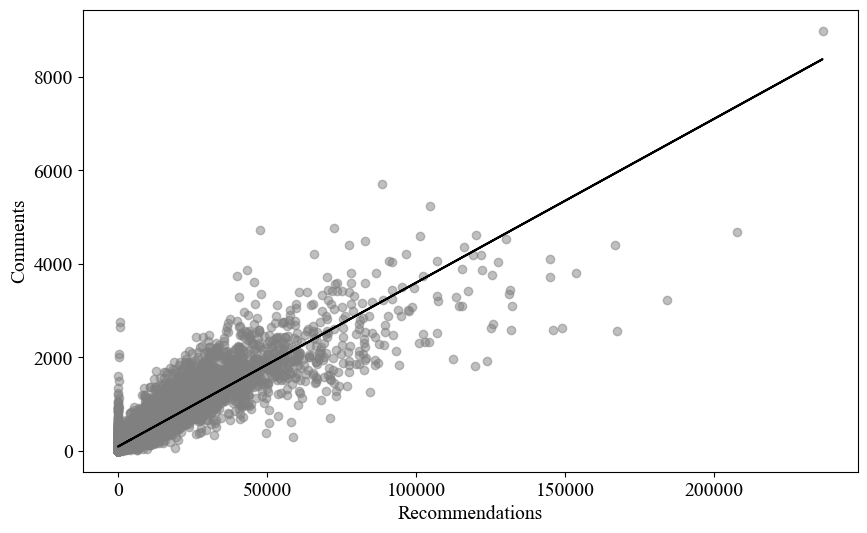

In [4]:
df = df_c.groupby('articleID').agg({
    'recommendations': 'sum',
    'userID': 'nunique',
    'commentID': 'count'})

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['recommendations'], df['commentID'], alpha=0.5, color='gray')  # Use gray for the points
ax.set_xlabel('Recommendations')
ax.set_ylabel('Comments')
#ax.set_title('Scatter Plot of Recommendations vs. Comments per Article')

# Optional: Fit line to highlight trend
m, b = np.polyfit(df['recommendations'], df['commentID'], 1)
ax.plot(df['recommendations'], m*df['recommendations'] + b, color='black')  # Use black for the trend line

plt.show()

In [ ]:
'''
Check how many comments have been posted by useres with a title, aka employeed people by the NYT. (column has been dropped in main df)
This users are not to be reguarded in our opinion leader detection but might play a crucial role in the effect section.
'''

df_c[df_c['userTitle'].notna()].userTitle.value_counts()


#'''
# In total only 6k coments have been made by modereators of the forum. 
#'''

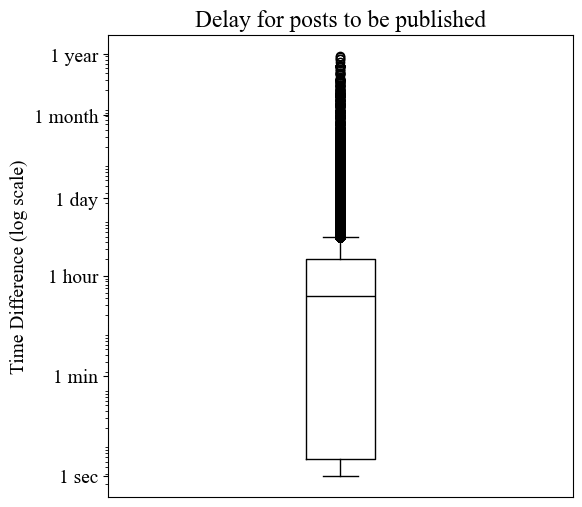

In [14]:
'''
IDentifying the difference between the time a comment has been written and the time it is has been aproved and posted
'''
difference_df = pd.DataFrame()
df_c['time_difference'] = pd.to_timedelta(df_c['approveDate'] - df_c['createDate'])
df_c['time_difference_pos'] = (df_c['time_difference'] > pd.Timedelta(hours=0))
positive_differences = df_c[df_c['time_difference_pos']]['time_difference']
positive_differences_hours = positive_differences.dt.total_seconds() / 3600

plt.figure(figsize=(6, 6)) 
box = plt.boxplot(positive_differences_hours, vert=True, patch_artist=False,)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(box[element], color='black')
    
plt.yscale('log')
tick_marks = [1/3600, 1/60, 1, 24, 720, 8760]
tick_labels = ['1 sec', '1 min', '1 hour', '1 day', '1 month', '1 year']

plt.yticks(tick_marks, tick_labels)
plt.title('Delay for posts to be published')
plt.ylabel('Time Difference (log scale)')
plt.xticks([])
plt.show()

print(df_c.loc[df_c.time_difference_pos]['time_difference'].describe())

Text(0.5, 1.0, 'Lorenz Plot for Comments per User')

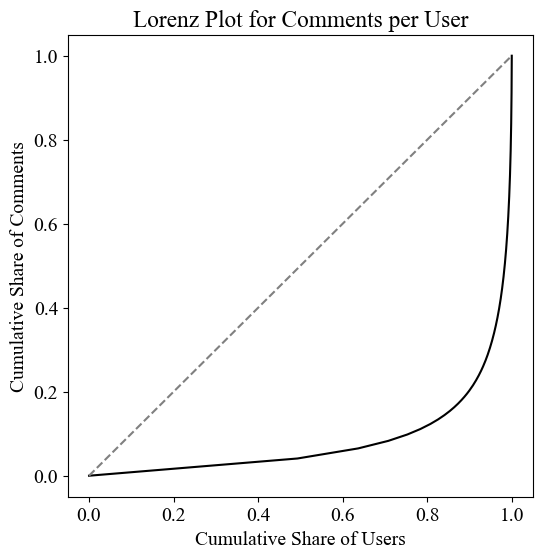

In [17]:
sorted_comment_count = df_c.groupby(["userID"]).count().sort_values(by=['commentBody'], ascending= False).commentBody.tolist()
sorted_comments = np.sort(sorted_comment_count)
cumulative_percentage = np.cumsum(sorted_comments) / np.sum(sorted_comments)

plt.figure(figsize=(6, 6))
plt.plot(np.linspace(0, 1, len(cumulative_percentage)), cumulative_percentage, linestyle='-', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Set labels and title
plt.xlabel('Cumulative Share of Users')
plt.ylabel('Cumulative Share of Comments')
plt.title('Lorenz Plot for Comments per User')

Text(0.5, 0, 'Users ')

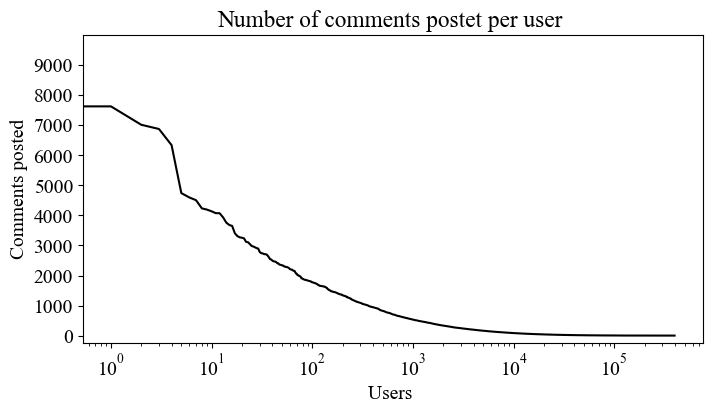

In [18]:
sorted_comment_count = df_c.groupby(["userID"]).count().sort_values(by=['commentBody'], ascending= False).commentBody.tolist()
plt.figure(figsize=(8, 4))
plt.plot(sorted_comment_count,color="black")
plt.xscale("log")

plt.ylim(-250, 10000)
plt.yticks(np.arange(0, 10000, step=1000))

plt.title("Number of comments postet per user ")
plt.ylabel("Comments posted")
plt.xlabel("Users ")

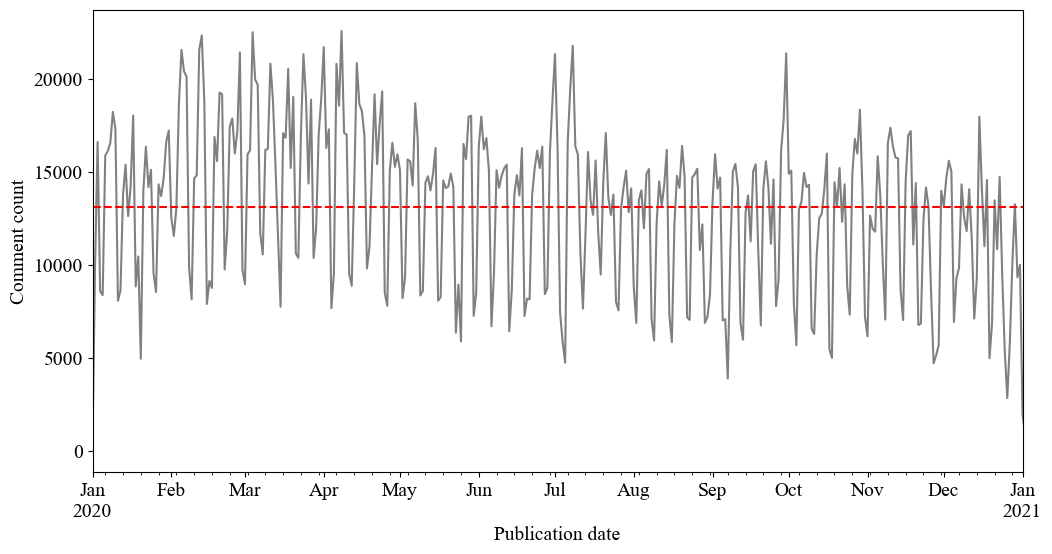

In [20]:
df_p = df_c.set_index('createDate').groupby(pd.Grouper(freq='D')).count().reset_index()
start_date = "2020-01-01"
end_date = "2021-01-01"

mean_comment_count = df_p[(df_p['createDate'] >= pd.to_datetime(start_date)) & (df_p['createDate'] <= pd.to_datetime(end_date))]['commentID'].mean()
ax = df_p.plot(x="createDate", y="commentID",
               xlabel="Publication date",
               ylabel="Comment count",
               xlim=["2020-01-01 00:00:00+00:00", "2021-01-01 00:00:00+00:00"],
               color='gray',
               legend=False,
               figsize=(12, 6))
ax.axhline(y=mean_comment_count, color='red', linestyle='--')
plt.show()

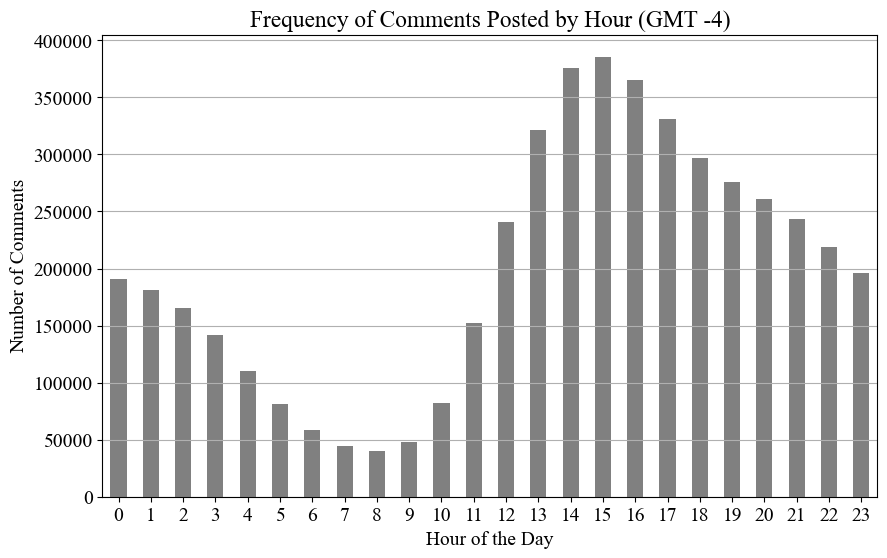

In [21]:
'''
PLotting at what time of the day a comment has been posted 
'''
df_c['hour'] = df_c['createDate'].dt.hour
plt.figure(figsize=(10, 6))
df_c['hour'].value_counts().sort_index().plot(kind='bar',color='gray')

#plt.axvline(x=(18) % 24, color='black', linestyle='--', label='CET')

plt.title('Frequency of Comments Posted by Hour (GMT -4)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

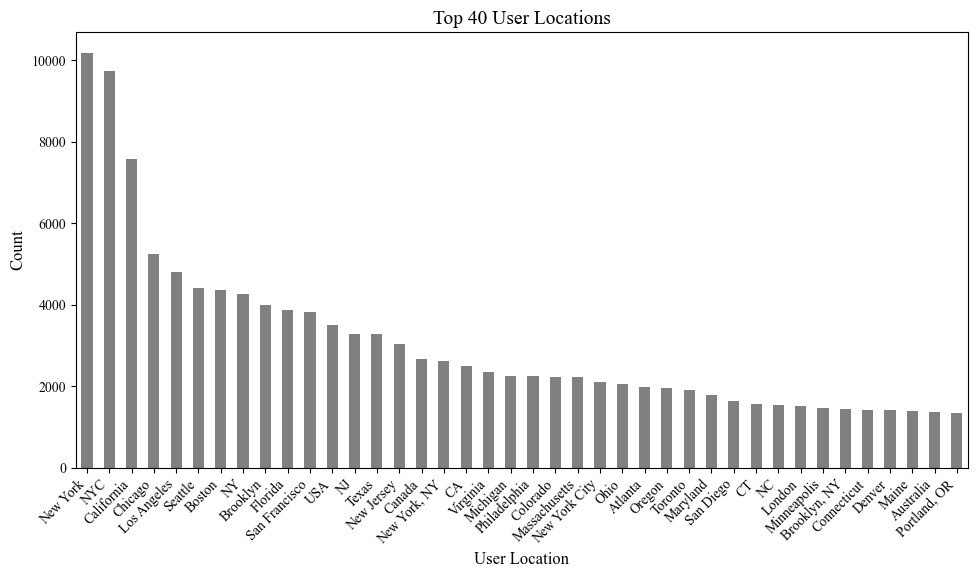

In [22]:
plt.figure(figsize=(10, 6))
df_c.drop_duplicates(subset=["userID"], keep='last')['userLocation'].value_counts().head(40).plot(kind='bar', color='gray')
plt.title('Top 40 User Locations', fontsize=14)
plt.xlabel('User Location', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()